In [1]:
# Enable if on M1/2 mac
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import src.halfar_ice as hi
from src.inference import run_inference
import torch
from torch import tensor as tnsr
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import numpy as np

plt.rcParams.update({
    'font.family': 'Courier New',
    'font.size': 10,
    'figure.facecolor': 'lightgray',
    'axes.facecolor': 'lightgray',
})

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Simulation of an Ice Dome

Iteration 00299/300


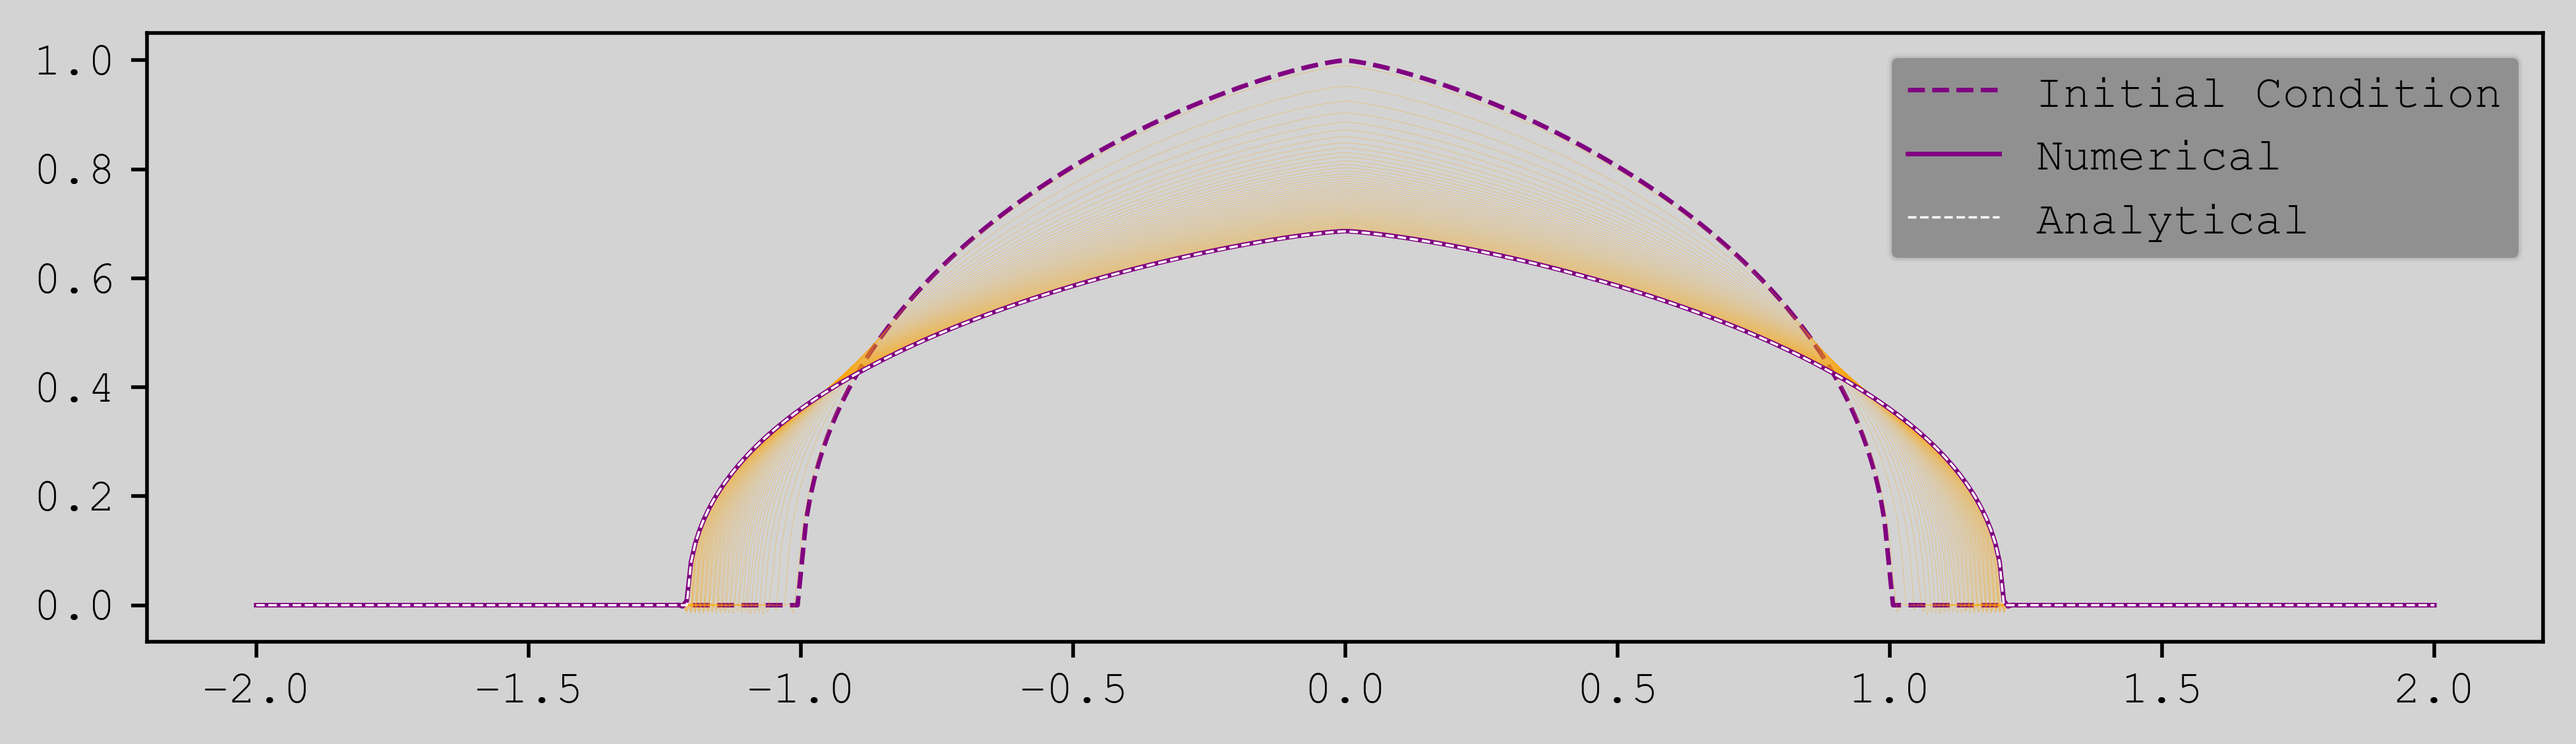

In [3]:
# Instantiate the numeric halfar ice model
num_hi_model = hi.HalfarIceNonLinearPolar(
    n_elements=511,
    solver_parameters={'newton_solver': {
        "maximum_iterations": 100,
        # "relative_tolerance": 1e-6,
        # "absolute_tolerance": 1e-6,
    }}
)

# Domain will be from -2. to 2. HalfarIceNonLinearPolar uses a lagrangian FE space of degree 1, meaning
#  our solutions will have n_elements + 1 points. x here is the radius of a radially symmetric dome of ice.
xx = torch.linspace(-2., 2., num_hi_model.n_elements + 1).double()

# Declare some ground truth parameters affecting flow and deformation rates.
true_ice_density = tnsr(910.).double()
true_log_flow_rate = torch.log(tnsr(1e-16)).double()

# The initial height and radius of the glacier in the standard dome shape.
h0, r0 = 1., 1.

# The gamma term is a constant affecting overall flow rates.
gamma = hi.stable_gamma(rho=true_ice_density, lA=true_log_flow_rate)

t0 = 0.0

# Generate a halfar dome — with the above parameters — as the initial condition.
u_init = hi.halfar_ice_analytical(r=xx, t=t0, h0=h0, r0=r0, gamma=gamma)
# Massage into a shape expected by torch-fenics, and declare this as a leaf tensor for gradients.
u_init = u_init[None, :].double().clone().detach().requires_grad_(True)

# We'll employ a time stepping solution, so declare the initial condition as the last solution.
u_last_t = u_init

# Prepare a list of solutions vectors (one for each timestep).
sols = [u_last_t[0]]

# Our timestep is 1000...time units (years? days?)
tstep = tnsr(1000).double()[None, None]

# Take 300 steps of 1000...time units.
num_steps = 300
for i in range(num_steps):
    print(f"\rIteration {i:05d}/{num_steps}", end='')

    # Execute the solver and append the solution to the list.
    u_last_t = num_hi_model(tstep, u_last_t, *torch.atleast_2d(true_ice_density, true_log_flow_rate))
    sols.append(u_last_t[0])
print()

fig, ax = plt.subplots(dpi=500, figsize=(8, 4))
hi.plot_sols(xx, sols, ax, skip=5, final_sol_lbl="Numerical")

# Compute the analytical solution at the end (absolute) time.
analytical_end_state = hi.halfar_ice_analytical(xx, t=t0 + num_steps * tstep.item(), h0=h0, r0=r0, gamma=gamma)

plt.plot(xx, analytical_end_state, color='white', linestyle='--',
         linewidth=0.5, label="Analytical")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend(facecolor='gray')
plt.show()

In [4]:
# As an aside, both the analytical and numeric solutions operate in polar coordinates, and thus their preservation of volume
#  (due to constant density and no flux boundary conditions) can only be seen when scaling by the radius.
print(f"Glacier Mass Before == c*{(xx.abs() * sols[0]).sum().item()}")
print(f"Glacier Mass After == c*{(xx.abs() * sols[-1]).sum().item()}")

Glacier Mass Before == c*80.31409462729549
Glacier Mass After == c*80.31409415316097


### Gradients

In [5]:
# Now, we check for proper gradients.
# Grab a point just the left of center.
poi_idx = num_hi_model.n_elements // 2 - 10

# Get gradients of the final dome height at that point.
poi = sols[-1][poi_idx]
poi.backward()

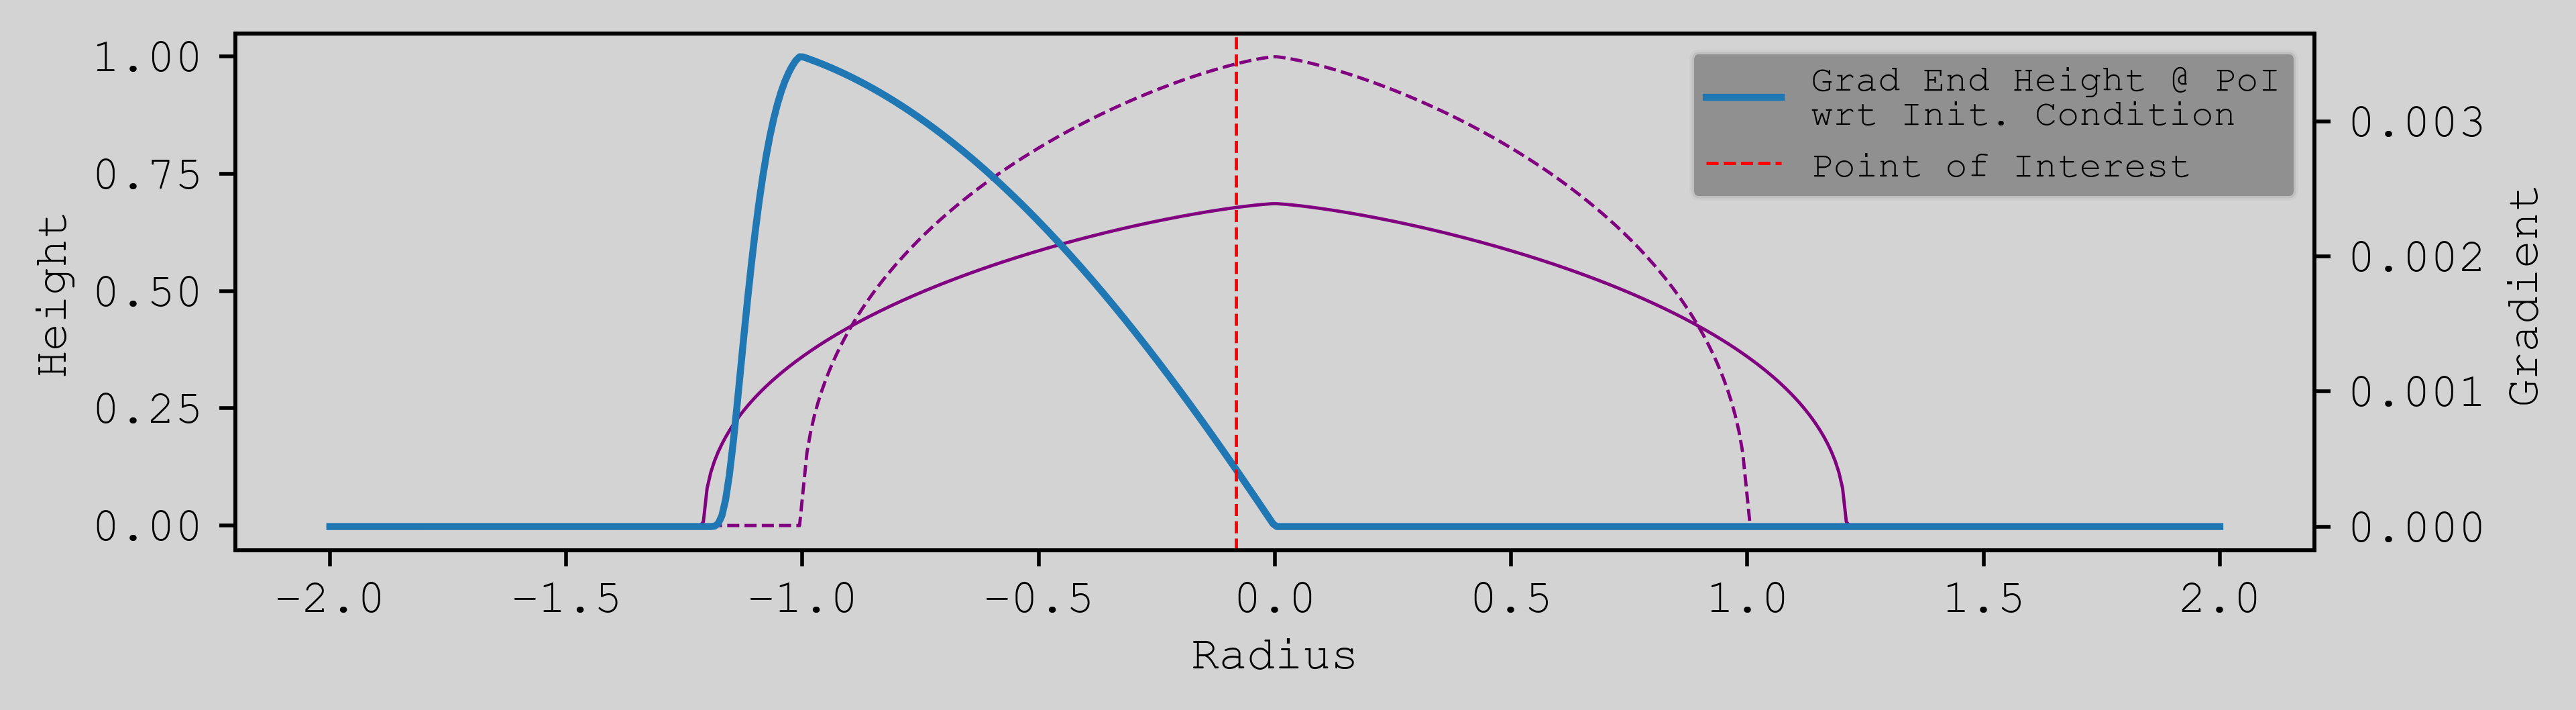

In [6]:
_, ax1 = plt.subplots(figsize=(8, 2), dpi=500)

ax1.plot(xx, u_init[0].detach(), color='purple', linestyle='--', linewidth=0.7)
ax1.plot(xx, sols[-1].detach(), color='purple', linewidth=0.7)
ax1.set_ylabel("Height")
ax1.set_xlabel("Radius")

ax2 = ax1.twinx()
ax2.plot(xx, u_init.grad[0].detach(), label='Grad End Height @ PoI\nwrt Init. Condition')
ax2.axvline(xx[poi_idx], color='red', linestyle='--', label='Point of Interest', linewidth=0.7)
ax2.set_ylabel("Gradient")
ax2.legend(facecolor='gray', fontsize=8)

### Modeling Glacier Depth Measurements

In [7]:
# Analytically simulate a glacier and noisily measure its depth at 10 separate times across 5 points on the left slope.
measurement_times = tnsr([t0 + tstep.item() * i for i in range(0,50,5)]).double() + tstep.item() * 5
# We'll take measurements on the mesh.
# TODO figure out measurements that are not on the mesh/adapt the mesh to observations.
measurement_poi_idx = torch.linspace(130, 256, 5, dtype=torch.int64)
measurement_poi = xx[measurement_poi_idx]

# Generate the true depths.
true_depths = hi.halfar_ice_analytical(r=measurement_poi[None, :], t=measurement_times[:, None], h0=h0, r0=r0, gamma=gamma)

In [8]:
print(measurement_times[:, None].numpy().round())

[[ 5000.]
 [10000.]
 [15000.]
 [20000.]
 [25000.]
 [30000.]
 [35000.]
 [40000.]
 [45000.]
 [50000.]]


##### Define a Measurement Noise Model in Pyro

In [9]:
def measurement_noise(true_depths_, noise_scale=0.05):
    return pyro.sample("measurements", dist.Normal(true_depths_, noise_scale).to_event(2))
measurements = measurement_noise(true_depths)

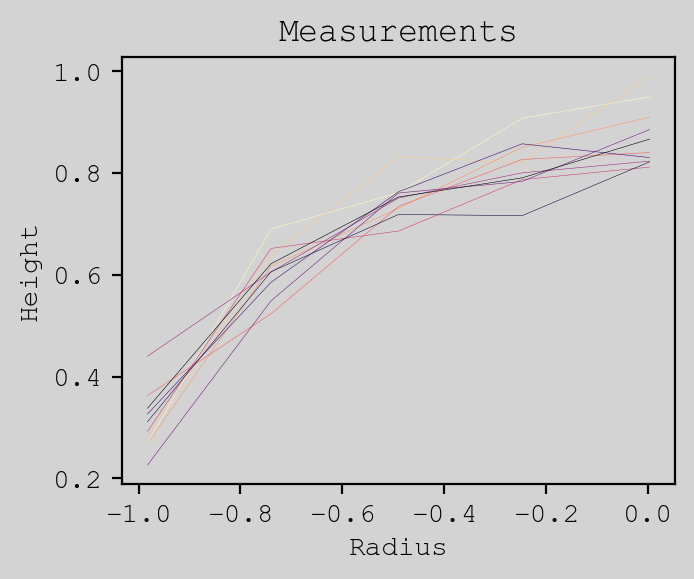

In [10]:
# Show measurements, in decreasing in lightness with recency.
_, ax = plt.subplots(dpi=200, figsize=(4, 3))
for i in range(measurements.shape[0]):
    recency = i / (measurements.shape[0] - 1)
    ax.plot(measurement_poi, measurements[i, :], color=plt.cm.magma(1. - recency), linewidth=0.2, alpha=1.)
ax.set_ylabel("Height")
ax.set_xlabel("Radius")
ax.set_title("Measurements")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

##### Full Observational Model

In [11]:
USE_ANALYTIC_INFERENCE = False

In [12]:
DENSITY_RANGE = np.array((810, 940))
LOG_FLOW_RATE_RANGE = np.log(np.array((1e-20, 1e-15)))

# Define normal priors for the ice density and flow rate.
def prior():
    # return pyro.sample("ice_density", dist.Normal(DENSITY_RANGE.mean(), np.ptp(DENSITY_RANGE) / 3.)).double(), \
    #        pyro.sample("log_flow_rate", dist.Normal(LOG_FLOW_RATE_RANGE.mean(), np.ptp(LOG_FLOW_RATE_RANGE) / 3.)).double()
    return pyro.sample("ice_density", dist.Uniform(*DENSITY_RANGE)).double(), \
           pyro.sample("log_flow_rate", dist.Uniform(*LOG_FLOW_RATE_RANGE)).double()

In [13]:
# Define a model
# noinspection PyShadowingNames
def num_true_depth_model(t0, ts, u0, ice_density, log_flow_rate, max_tspan):
    """

    :param t0: The initial, absolute time of the initial condition. (scalar)
    :param ts: The absolute times at which to solve for the glacier's height. (vector)
    :param u0: The initial state of the mesh at t=0. (vector)
    :param ice_density: The density of the ice (rho). (scalar)
    :param log_flow_rate: The log of the flow rate (log(A)). (scalar)
    :param max_tspan: The maximum time span to solve for at once. (scalar)
    :return: The heights of the glacier at each time and measurement radius (with shape (len(ts), len(measurement_poi_idx))). (matrix)
    """

    max_tspan = tnsr(max_tspan).double()

    true_depths = []

    # Initialize the iteratively updated solution.
    ul = u0

    tl = tnsr(t0).double()
    for t in ts:

        if USE_ANALYTIC_INFERENCE:
            ul = hi.halfar_ice_analytical(r=xx, t=t, h0=h0, r0=r0, gamma=hi.stable_gamma(rho=ice_density, lA=log_flow_rate), differentiable=True)
        else:
            try:
                while t - tl > max_tspan:
                    # Solve for the solution at the maximum time span.
                    ul = num_hi_model(*torch.atleast_2d(max_tspan, ul, ice_density, log_flow_rate))[0]
                    tl = tl + max_tspan
                else:
                    # TODO adapt both the mesh and the spatial domain (e.g. to exclude the numerically unstable glacier edges) to focus
                    #  on the regions of interest (where the observations occurred).
                    ul = num_hi_model(*torch.atleast_2d(t - tl, ul, ice_density, log_flow_rate))[0]
            except RuntimeError:
                print(f"Failed at t={t.item():.2f} with ice_density={ice_density.item():.2f} and flow_rate={log_flow_rate.exp().item()}")
                raise

        tl = t

        # Append the solution at this time to the list.
        true_depths.append(ul[measurement_poi_idx])

    return torch.stack(true_depths)

In [14]:
# noinspection PyShadowingNames
def model(max_tspan=1000.):
    # Sample the ice density and flow rate from the prior.
    ice_density, log_flow_rate = prior()

    # Solve for the true depths at the measurement times.
    # Note: assume a fully known u_init for now.
    true_depths = num_true_depth_model(t0, measurement_times, u_init, ice_density, log_flow_rate, max_tspan=max_tspan)

    # Sample the measurements from the measurement noise model.
    return measurement_noise(true_depths)

### Inference

In [15]:
losses = []

if USE_ANALYTIC_INFERENCE:
    guide = pyro.infer.autoguide.AutoIAFNormal(
        prior,
        num_transforms=3
    )

else:
    guide = pyro.infer.autoguide.AutoMultivariateNormal(
        prior,
        init_loc_fn=pyro.infer.autoguide.init_to_median,
        init_scale=0.1
    )

In [16]:
# noinspection PyShadowingNames
def infer(steps, lr, guide):
    with pyro.condition(data={"measurements": measurements}):
        return run_inference(
            model=model,
            prior=prior,
            guide=guide,
            steps=steps,
            # verbose=not USE_ANALYTIC_INFERENCE,
            verbose=False,
            verbose_every=10,
            max_retry_solve=100,
            lr=lr
        )

if USE_ANALYTIC_INFERENCE:
    losses_, guide = infer(5000, 1e-3, guide)
    losses.extend(losses_)
    losses_, guide = infer(5000, 5e-4, guide)
    losses.extend(losses_)
    losses_, guide = infer(5000, 1e-4, guide)
    losses.extend(losses_)
    losses_, guide = infer(10000, 5e-5, guide)
    losses.extend(losses_)
    losses_, guide = infer(10000, 1e-5, guide)
    losses.extend(losses_)
else:
    losses_, guide = infer(2000, 1e-3, guide)
    losses.extend(losses_)
    losses_, guide = infer(2000, 5e-4, guide)
    losses.extend(losses_)
    losses_, guide = infer(2000, 1e-4, guide)
    losses.extend(losses_)
    losses_, guide = infer(2000, 5e-5, guide)
    losses.extend(losses_)
    losses_, guide = infer(2000, 1e-5, guide)
    losses.extend(losses_)


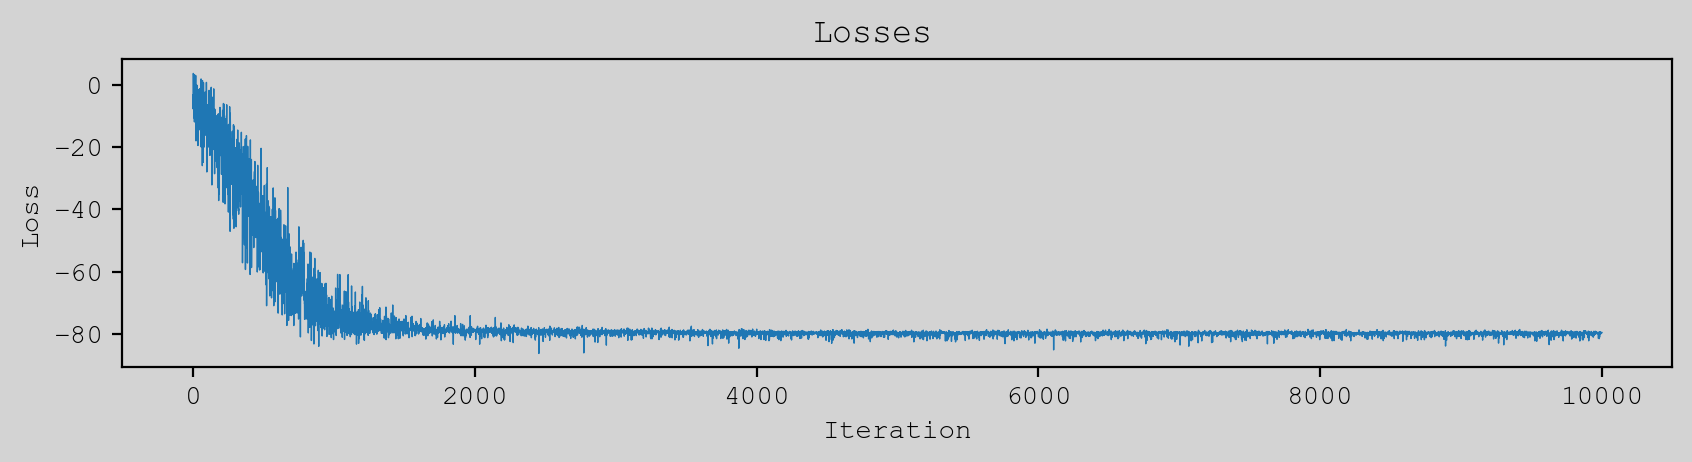

In [17]:
# Plot the losses.
plt.figure(figsize=(10, 2), dpi=200)
plt.suptitle("Losses")
plt.plot(losses, linewidth=0.5)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [18]:
# Plot scatter of posterior samples. TODO plot posterior density contours from guide.
posterior_samples = []
for i in range(5000):
    psample = guide()
    posterior_samples.append((psample["ice_density"].item(), psample["log_flow_rate"].item()))
posterior_samples = np.array(posterior_samples)

/var/folders/cy/bjbt3n4j2fn22yc8tb1wwmxm0000gp/T/ipykernel_73552/853884861.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{np.exp(tick):.1e}" for tick in ax.get_xticks()])


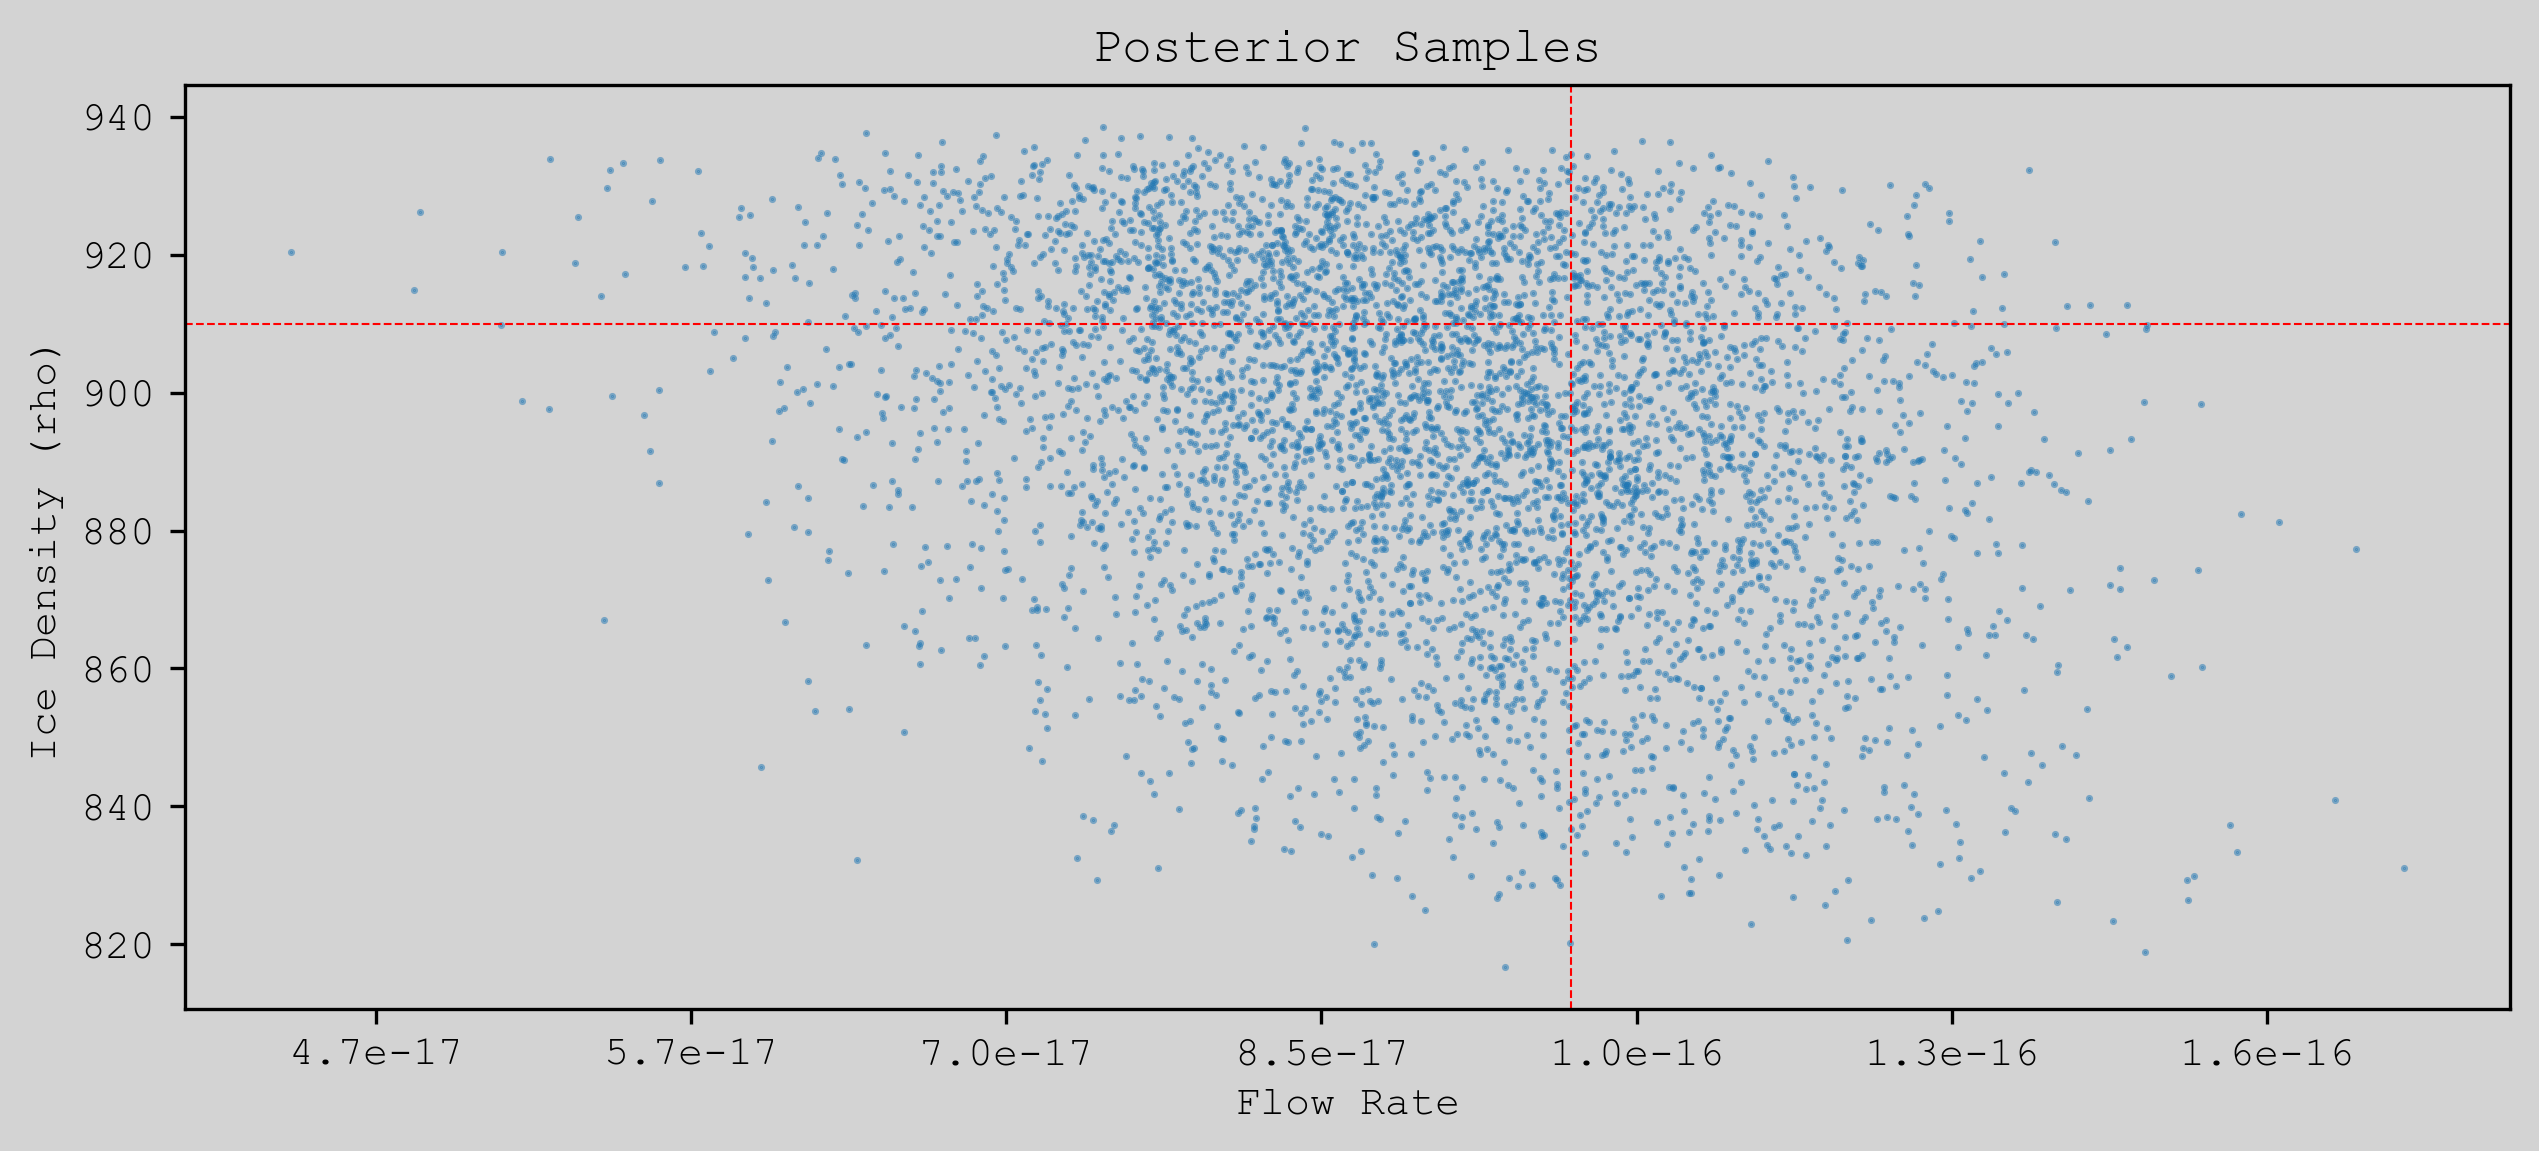

In [19]:
_, ax = plt.subplots(figsize=(10, 4), dpi=300)
ax.set_title("Posterior Samples")
ax.scatter(posterior_samples[:, 1], posterior_samples[:, 0], s=0.5, alpha=0.5)
ax.set_xticklabels([f"{np.exp(tick):.1e}" for tick in ax.get_xticks()])
ax.set_xlabel("Flow Rate")
ax.set_ylabel("Ice Density (rho)")

# Plot vline and hline at the true values. Use thin lines.
ax.axvline(true_log_flow_rate.item(), color='red', linestyle='--', linewidth=0.5)
ax.axhline(true_ice_density.item(), color='red', linestyle='--', linewidth=0.5)

plt.show()

### Prediction

In [20]:
# The future time at which to predict the glacier's form.
pred_time = ((measurement_times[-1] - t0) * 2 + t0).item()

In [21]:
# We want to compare the prior and posterior predictive distributions, so generate prior samples first.
prior_samples = torch.tensor([prior() for _ in range(5000)])
posterior_samples = torch.tensor(posterior_samples)

##### Analytical

In [22]:
# Prior and posterior predictive samples of glacier profiles at pred time, first, with the analytical solution.
prior_preds = hi.halfar_ice_analytical(r=xx[None, :], t=pred_time, h0=h0, r0=r0, gamma=hi.stable_gamma(rho=prior_samples[:, 0], lA=prior_samples[:, 1])[:, None])
posterior_preds = hi.halfar_ice_analytical(r=xx[None, :], t=pred_time, h0=h0, r0=r0, gamma=hi.stable_gamma(rho=posterior_samples[:, 0], lA=posterior_samples[:, 1])[:, None])

In [23]:
def get_pointwise_mul(preds):
    ret = preds.mean(dim=0), preds.quantile(0.95, dim=0), preds.quantile(0.05, dim=0)

    if isinstance(preds, torch.Tensor):
        return tuple(x.detach().numpy() for x in ret)
    return ret

def plot_preds(prior_preds, posterior_preds):

    # Get the pointwise mean, upper and lower quartiles for each predictive distribution.
    prior_mean, prior_upper, prior_lower = get_pointwise_mul(prior_preds)
    posterior_mean, posterior_upper, posterior_lower = get_pointwise_mul(posterior_preds)

    # Plot the prior and posterior predictive distributions.
    fig, ax = plt.subplots(dpi=500, figsize=(8, 4))

    ax.plot(xx, prior_mean, color='blue', linewidth=0.7, label="Prior Predictive", alpha=0.5)
    ax.fill_between(xx, prior_lower, prior_upper, color='blue', alpha=0.02)

    ax.plot(xx, posterior_mean, color='orange', linewidth=0.7, label="Posterior Predictive")
    ax.fill_between(xx, posterior_lower, posterior_upper, color='orange', alpha=0.1)

    ax.plot(xx, hi.halfar_ice_analytical(r=xx, t=pred_time, h0=h0, r0=r0, gamma=gamma), color='white', linestyle='--',
             linewidth=0.5, label="True")

    ax.set_ylabel("Height")
    ax.set_xlabel("Radius")
    ax.set_title("Analytical Prior and Posterior Predictive Distributions")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.legend(facecolor='gray', fontsize=7)
    plt.show()

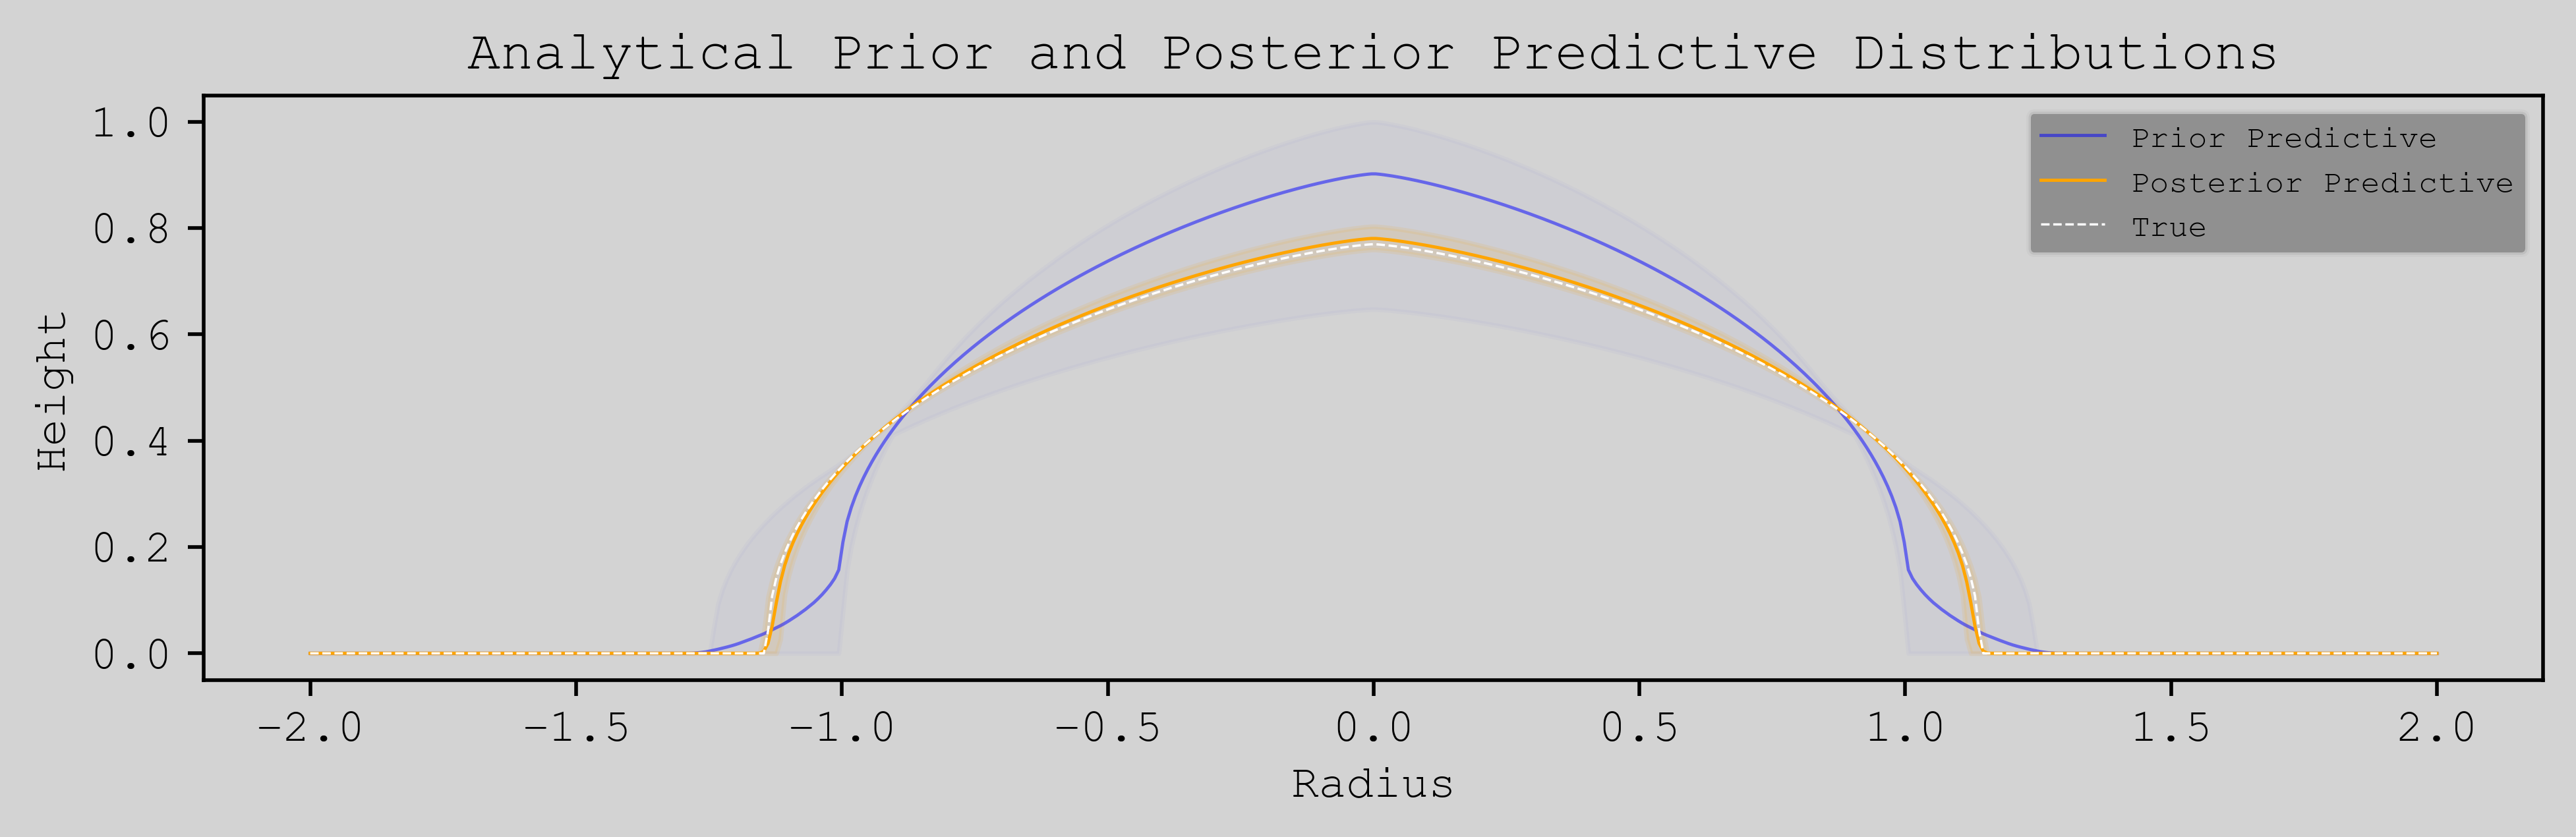

In [24]:
plot_preds(prior_preds, posterior_preds)

##### Numeric (Not Run in this Execution)

In [ ]:
from src.utils import specify_if_solver_did_not_converge, SolverDidNotConvergeOnce

# Prior and posterior predictive glacier distributions, now with the numeric solver.

num_hi_model_wrapped = specify_if_solver_did_not_converge(num_hi_model)

# noinspection PyShadowingNames
def get_converged_sols(pred_time, u_init, samples, num_sub_tsteps=10):
    remaining_samples = len(samples) + 1
    sols = []
    converged_samples = []
    unconverged_samples = []
    for ice_density, log_flow_rate in samples:

        remaining_samples -= 1
        print(f"\r{remaining_samples:05d} samples remaining; {len(sols):05d} samples converged", end='')

        # Subdivide the time interval into smaller steps.
        sub_tstep = (pred_time - t0) / num_sub_tsteps

        ul = u_init

        try:
            for i in range(num_sub_tsteps):
                ul = num_hi_model_wrapped(*torch.atleast_2d(sub_tstep, ul, ice_density, log_flow_rate))

            sols.append(ul[0])

            converged_samples.append((ice_density.item(), log_flow_rate.item()))
        except SolverDidNotConvergeOnce:
            unconverged_samples.append((ice_density.item(), log_flow_rate.item()))
            continue
    print()

    return torch.stack(sols), np.array(converged_samples), np.array(unconverged_samples)

In [ ]:
pred_time = tnsr(pred_time).double()

print("Solving for prior predictive samples.")
prior_preds, converged_samples, unconverged_samples = get_converged_sols(pred_time, u_init, prior_samples[:100])
print(f"Prior Predictive: {prior_preds.shape[0]} converged samples")

print("Solving for posterior predictive samples.")
posterior_preds, _, _ = get_converged_sols(pred_time, u_init, posterior_samples[:100])
print(f"Posterior Predictive: {posterior_preds.shape[0]} converged samples")

In [ ]:
plot_preds(prior_preds, posterior_preds)

### Diagnosing Non-Convergence

In [ ]:
# We want to run the solver with samples from the prior, see where they fail to converge, and then differentiate a scatter plot, by color,
#  of the samples that did and did not converge.
# TODO this isn't plotting exactly the convergence regions during inference, as the points in time evaluated here differ. That said,
#  this remains diagnostic.
_, ax = plt.subplots(figsize=(8, 4), dpi=500)

# Visualize regions of non-convergence.
ax.scatter(*np.fliplr(converged_samples).T, s=0.5, alpha=0.5, label="Converged", color='purple')
ax.scatter(*np.fliplr(unconverged_samples).T, s=0.5, alpha=0.5, label="Unconverged", color='orange')
ax.set_xticklabels([f"{np.exp(tick):.1e}" for tick in ax.get_xticks()])

# Visualize the true values.
ax.axvline(true_log_flow_rate.item(), color='red', linestyle='--', linewidth=0.5)
ax.axhline(true_ice_density.item(), color='red', linestyle='--', linewidth=0.5, label="True")

ax.legend(facecolor='gray', fontsize=9)
ax.set_xlabel("Flow Rate")
ax.set_ylabel("Ice Density (rho)")
ax.set_title("Convergence of Prior Samples")
plt.show()